# Main functions used in experiments

In [156]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [157]:
# from windy_gridworld import WindyGridworldEnv
# env = WindyGridworldEnv()
# env??

import gym
env = gym.envs.make("FrozenLake-v0")
env.env.__init__(is_slippery=False)
# env??

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [158]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [159]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        # for one state and action 
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
#         if (obs == 13): 
#             print(self.Q[obs])
        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice([i for i, j in enumerate(self.Q[obs]) if j == np.max(self.Q[obs])])
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [160]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [161]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.env.nS, env.env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 5


## Importance Sampling


In [162]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42, 
                           analyse_states=[(0,2), (0,1), (14,2), (2,1)]):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.zeros((env.env.nS, env.env.nA))
    if weighted:
        C = np.zeros((env.env.nS, env.env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * W * (G - Q[s][a])

            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
            
    return Q, episode_lens, analysis_values

## Performance


In [163]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.2
gamma = 0.99
num_episodes = 5000
Q = np.ones((env.env.nS, env.env.nA)) * 0
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


 19%|█▉        | 971/5000 [00:01<00:04, 970.28it/s]

Updating Q using weighted importance sampling (5000 episodes)


100%|██████████| 5000/5000 [00:04<00:00, 1062.37it/s]


In [164]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
greedy_weighted = GreedyPolicy(Q_mc_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


### Plotting episode lengths during training

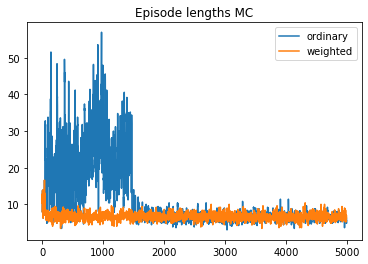

In [165]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

In [150]:
import math
def sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, 
                                       discount_factor=1.0, alpha=0.5, seed=42,
                                 analyse_states=[(0,2), (0,1), (14,2), (2,1)]):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    np.random.seed(seed)
    
    # Keep track of useful statistics
    stats = []
    
#     Q = np.ones((env.nS, env.nA)) * -100
    Q = np.zeros((env.env.nS, env.env.nA))
    C = np.zeros((env.env.nS, env.env.nA))
    returns_count = np.zeros((env.env.nS, env.env.nA))
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    for i_episode in tqdm(range(num_episodes), position=0):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            returns_count[s][a] += 1
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)                        
            
            if W == 0:
                break
            
            if weighted:
                # Update weight and C
                C[s][a] += W
                
                # importance weight is 1 
                Q[s][a] += W/C[s][a] * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            else:
                Q[s][a] += 1/returns_count[s][a] * W * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            
            W = (target_policy.get_probs(s_prime,a_prime))/(behavior_policy.get_probs(s_prime,a_prime))
    
            behavior_policy.Q[s][a] = Q[s][a]
            target_policy.Q[s][a] = Q[s][a]
            
            s = s_prime
            a = a_prime
            
            R += r
            
            if final_state:
                break
            
        stats.append((i, R))

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
    
    
    episode_lengths, episode_returns = zip(*stats)
    print(returns_count)
    print(Q)
    
    return Q, episode_lengths, analysis_values

In [151]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.2
gamma = 0.99
num_episodes = 5000
Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_sarsa_ordinary, sarsa_ordinary_epslengths, sarsa_analysis_ordinary = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,
                                                                         discount_factor=gamma, seed=seed)

Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)


print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_sarsa_weighted, sarsa_weighted_epslengths, sarsa_analysis_weighted = sarsa_importance_sampling(env, 
                                                                        behavioral_policy, target_policy,
                                                                        num_episodes, weighted=True,
                                                                        discount_factor=gamma, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


 20%|██        | 1016/5000 [00:01<00:03, 1015.71it/s]

[[3.660e+02 3.240e+02 4.858e+03 3.560e+02]
 [2.640e+02 2.980e+02 4.072e+03 2.660e+02]
 [2.000e+02 3.464e+03 2.160e+02 2.140e+02]
 [5.000e+00 2.000e+00 4.000e+00 6.000e+00]
 [5.200e+01 4.000e+01 4.800e+01 2.060e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.790e+02 2.925e+03 1.870e+02 1.730e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.200e+01 1.000e+01 1.100e+01 1.300e+01]
 [6.000e+00 2.000e+00 2.000e+00 3.000e+00]
 [1.530e+02 2.502e+03 1.430e+02 1.290e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 1.000e+00]
 [1.310e+02 1.170e+02 2.128e+03 1.260e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
[[0.03299329 0.01048745 0.12974443 0.03201719]
 [0.         0.         0.26792953 0.        ]
 [0.         0.43084549 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.05353216]
 [0.         0.         0.         0.        ]
 [0.         0.62286823 0.   

100%|██████████| 5000/5000 [00:04<00:00, 1053.51it/s]

[[3.660e+02 3.240e+02 4.858e+03 3.560e+02]
 [2.640e+02 2.980e+02 4.072e+03 2.660e+02]
 [2.000e+02 3.464e+03 2.160e+02 2.140e+02]
 [5.000e+00 2.000e+00 4.000e+00 6.000e+00]
 [5.200e+01 4.000e+01 4.800e+01 2.060e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.790e+02 2.925e+03 1.870e+02 1.730e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.200e+01 1.000e+01 1.100e+01 1.300e+01]
 [6.000e+00 2.000e+00 2.000e+00 3.000e+00]
 [1.530e+02 2.502e+03 1.430e+02 1.290e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 1.000e+00]
 [1.310e+02 1.170e+02 2.128e+03 1.260e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
[[0.02474892 0.00709484 0.0923059  0.02392808]
 [0.         0.         0.19842003 0.        ]
 [0.         0.35646018 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.03384422]
 [0.         0.         0.         0.        ]
 [0.         0.56409049 0.   

In [153]:
# check how long an episode takes under the found Q function
sarsa_greedy_ordinary = GreedyPolicy(Q_sarsa_ordinary)
sarsa_greedy_weighted = GreedyPolicy(Q_sarsa_weighted)

sarsa_ordinary_episode = sample_episode(env, sarsa_greedy_ordinary)
sarsa_weighted_episode = sample_episode(env, sarsa_greedy_weighted)

print(f"resulting episode length ordinary: {len(sarsa_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(sarsa_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


In [154]:
def plot_values(state, action):
    plt.plot(np.arange(0,5000), sarsa_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), sarsa_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes TD")
    plt.show()
    
    plt.plot(np.arange(0,5000), mc_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), mc_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes MC")
    plt.show()

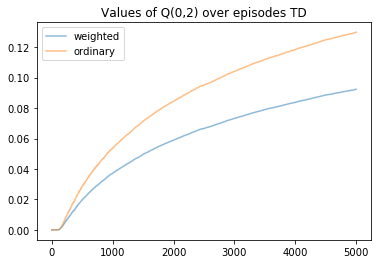

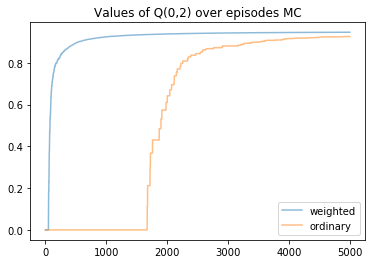

In [178]:
plot_values(0,2)

In [135]:
def n_step_sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, n=1, weighted=False, 
                                       discount_factor=1.0, alpha=0.5, seed=42,
                                 analyse_states=[(0,2), (0,1), (14,2), (2,1)]):

    
    np.random.seed(seed)
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.zeros((env.env.nS, env.env.nA))
    C = np.zeros((env.env.nS, env.env.nA))
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
        
        s = defaultdict(lambda: defaultdict(float))
        a = defaultdict(lambda: defaultdict(float))
        r = defaultdict(lambda: defaultdict(float))
            
        s[0] = env.reset()
        a[0] = behavior_policy.sample_action(s[0])
        
        T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1
                
                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])
            
            tau = t - n
            
            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]
                
                # n-step importance sampling ratio
                rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])
                
                # n-step return
                last_step_G = min([tau + n, T+1])
                G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
                if tau + n < T:
                    G += discount_factor**n * Q[s[tau+n]][a[tau+n]]

                # Update Q - ordinary importance sampling: divided by number of steps? 
                if weighted:
                    Q[s[tau]][a[tau]] += alpha * (G - Q[s[tau]][a[tau]])
                else:
                    Q[s[tau]][a[tau]] += alpha * rho * (G - Q[s[tau]][a[tau]])
#             print((G - Q[s[tau]][a[tau]]))
            if tau == T:
                break
                         
            t += 1

        stats.append((i, R))
        
        for (s,a) in analyse_states:
            analysis_values[(s,a)].append(Q[s][a])
    
    episode_lengths, episode_returns = zip(*stats)
    
    return Q, episode_lengths, analysis_values

In [114]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.2
gamma = 0.99
num_episodes = 5000
Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_nstep_ordinary, nstep_ordinary_epslengths, nstep_analysis_ordinary = n_step_sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, n=1, weighted=False,
                                                                         discount_factor=gamma, seed=seed)

Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)


print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_nstep_weighted, nstep_weighted_epslengths, nstep_analysis_weighted = n_step_sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, n=1, weighted=True,
                                                                         discount_factor=gamma, seed=seed)



  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [94]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_nstep_ordinary)
greedy_weighted = GreedyPolicy(Q_nstep_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 2
resulting episode length weighted: 4


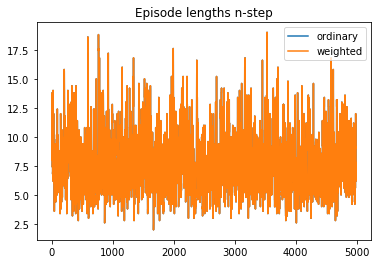

In [95]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(nstep_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(nstep_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths n-step')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

In [72]:
s = env.reset()
env.render()
env.step(3)
env.render()


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
